# Metody Obliczeniowe w Nauce i Technice
## Laboratorium 10 - Dyskretna Transformacja Fouriera
### Albert Gierlach

Użyta wersja pythona:

* Python 3.8.3 64bit

Użyte biblioteki:

* numpy 1.18.2
* matplotlib 3.2.1

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false; 
}

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mtplt
import random
import time

np.set_printoptions(precision=3)
mtplt.rcParams['figure.figsize'] = [18, 9] # plots size

#### 1. FFT
Na początku zaimplementowałem funkcję zwracającą wektor o długości \\(2^r\\)

In [3]:
def get_random_vec(r=None):
    if not r:
        r = random.randint(1, 10)
    n = 2 ** r
    return np.random.uniform(low=-10, high=10, size=n)

Później zaimplementowałem funkcję wyznaczającą macierz Fouriera o zadanym rozmiarze (\\(F_n\\)) oraz funkcję obliczającą DFT, czyli mnożącą wyliczoną macierz (\\(F_n\\)) przez wektor \\(x\\)

In [4]:
def fourier_matrix(n):
    def dzeta(j, k):
        return np.exp(((-2j) * np.pi) / n) ** (j * k)

    return np.array([dzeta(j, k) for j in range(n) for k in range(n)], dtype=np.complex).reshape((n, n))


def dft(x):
    n = x.shape[0]
    F = fourier_matrix(n)

    return F @ x, F

Następnie korzystając z podanej w punkcie drugim tożsamości zaimplementowałem IDFT.

In [5]:
def idft(F, y):
    return (np.conjugate(F @ np.conjugate(y))) / y.shape[0]

Mając zaimplementowane DFT oraz IDFT sprawdziłem poprawność obliczeń dla dziesięciu losowych wektorów porównując wyniki z funkcją biblioteczną np.fft

In [6]:
for _ in range(10):
    x = get_random_vec()
    y, F = dft(x)
    x_ = idft(F, y)
    print("(dft == numpy fft)? ", end='')
    print(np.allclose(y, np.fft.fft(x), rtol=1e-6) and np.allclose(np.real(x_), x, rtol=1e-6))

(dft == numpy fft)? True
(dft == numpy fft)? True
(dft == numpy fft)? True
(dft == numpy fft)? True
(dft == numpy fft)? True
(dft == numpy fft)? True
(dft == numpy fft)? True
(dft == numpy fft)? True
(dft == numpy fft)? True
(dft == numpy fft)? True


Jak widać wyniki są poprawne. Kolejną funkcją zaimplementowaną przeze mnie jest rekursywny algorytm Cooleya-Turkeya.

In [7]:
def fft_recursive(x):
    n = x.shape[0]

    if n == 1:
        return x[0]

    even_x = fft_recursive(x[::2])
    odd_x = fft_recursive(x[1::2])
    f = np.exp((np.pi * (-2j) * np.arange(n)) / n)
    return np.concatenate([even_x + f[:n//2] * odd_x, even_x + f[n//2:] * odd_x])

Sprawdziłem poprawność implementacji za pomocą zmodyfikowanej metody użytej wcześniej.

In [8]:
for _ in range(10):
    x = get_random_vec()
    print("(fft_recursive == numpy fft)? ", end='')
    print(np.allclose(fft_recursive(x), np.fft.fft(x), rtol=1e-6))

(fft_recursive == numpy fft)? True
(fft_recursive == numpy fft)? True
(fft_recursive == numpy fft)? True
(fft_recursive == numpy fft)? True
(fft_recursive == numpy fft)? True
(fft_recursive == numpy fft)? True
(fft_recursive == numpy fft)? True
(fft_recursive == numpy fft)? True
(fft_recursive == numpy fft)? True
(fft_recursive == numpy fft)? True


Na końcu zaimplementowałem funkcjonalność do porównywania czasów poszczególnych metod transformacji Fouriera.

In [9]:
def timeit(func):
    startTime = time.perf_counter()
    return func(), round(time.perf_counter() - startTime, 4)

In [10]:
format_str = "|{:^11}|{:^15}|{:^15}|{:^15}|{:^8}|"
print(format_str.format("Vec size", "DFT", "Cooley-Turkey", "numpy fft", "Valid?"))
for r in range(1, 12):
    x = get_random_vec(r)
    res1, time1 = timeit(lambda: dft(x)[0])
    res2, time2 = timeit(lambda: fft_recursive(x))
    res3, time3 = timeit(lambda: np.fft.fft(x))

    valid = np.allclose(res1, res2) and np.allclose(res2, res3)

    print(format_str.format(2 ** r, time1, time2, time3, "True" if valid else "False"))

| Vec size  |      DFT      | Cooley-Turkey |   numpy fft   | Valid? |
|     2     |    0.0001     |      0.0      |      0.0      |  True  |
|     4     |    0.0002     |    0.0002     |    0.0001     |  True  |
|     8     |    0.0002     |    0.0001     |      0.0      |  True  |
|    16     |    0.0005     |    0.0003     |      0.0      |  True  |
|    32     |     0.003     |    0.0014     |      0.0      |  True  |
|    64     |    0.0091     |    0.0015     |    0.0001     |  True  |
|    128    |     0.034     |    0.0018     |      0.0      |  True  |
|    256    |    0.1339     |    0.0036     |      0.0      |  True  |
|    512    |    0.5241     |    0.0066     |      0.0      |  True  |
|   1024    |     2.103     |    0.0129     |      0.0      |  True  |
|   2048    |    9.5085     |    0.0646     |    0.0001     |  True  |


Jak pokazują wyniki - wszystkie trzy metody są ze sobą zgodne co do wyniku. Problem pojawia się w czasie wykonania. DFT jest najwolniejsze ze względu na swoją złożoność \\(O(n^2)\\). Algorytm Cooleya-Turkeya działa ze złożonością \\(O(nlogn)\\). Algorytm z biblioteki numpy także używa algorytmu Cooleya-Turkeya, ale robi to efektywniej.

#### 2. DFT w 1D

W celu wygenerowania pożądanych sygnałów zaimplementowałem funkcję, która tworzy pięć funkcji sinusoidalnych o różnych częstotliowościach. Później stworzyłem funkcję, która dodaje wszystkie pięć sygnałów i tworzy z nich jeden, a także funkcję, która zawiera kawałek każdej z pięciu funkcji.

In [19]:
DATA_SIZE = 512
def get_signals(n):
    xs = np.linspace(0, 50, DATA_SIZE)
    ys_ = []

    for i in range(1, n+1):
        ys = np.sin(xs * i)
        ys_.append(ys)

    return xs, ys_


def plot_signals(xs, ys):
    plt.subplots_adjust(hspace=1)
    for i, y in enumerate(ys):
        plt.subplot(5, 1, i+1)
        plt.title("sin({}π)".format(i+1))
        plt.plot(xs, y)

    plt.show()


def get_overlapping_signal(ys):
    return [sum(i) for i in zip(*ys)]


def get_concatenated_signal(ys):
    res = []
    divider = DATA_SIZE / 5
    for i, v in enumerate(ys):
        res.extend(v[round(i*divider):round((i+1)*divider)])

    return res

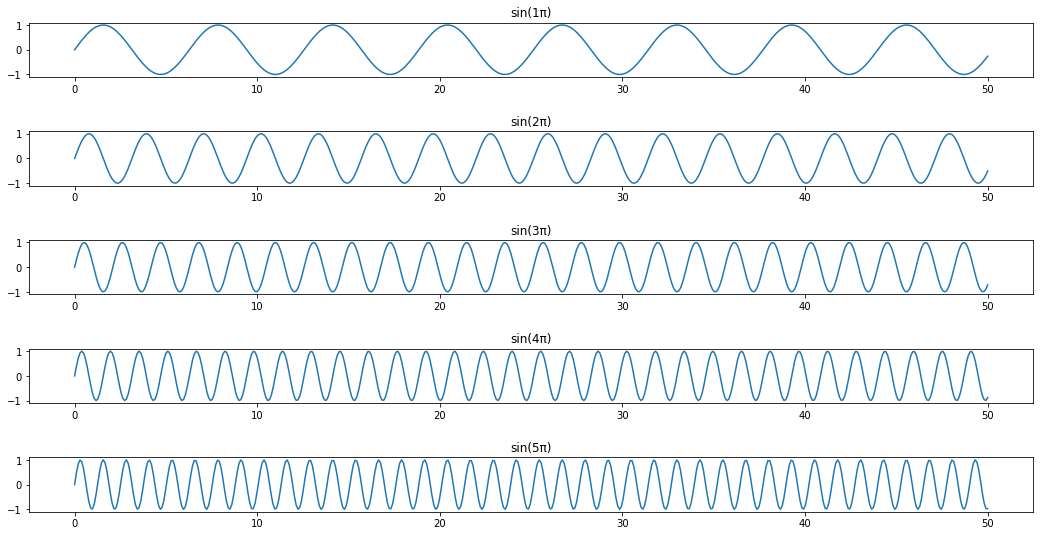

In [20]:
xs, ys = get_signals(5)
plot_signals(xs, ys)

In [13]:
overlapped_signal = get_overlapping_signal(ys)
concatenated_signal = get_concatenated_signal(ys)

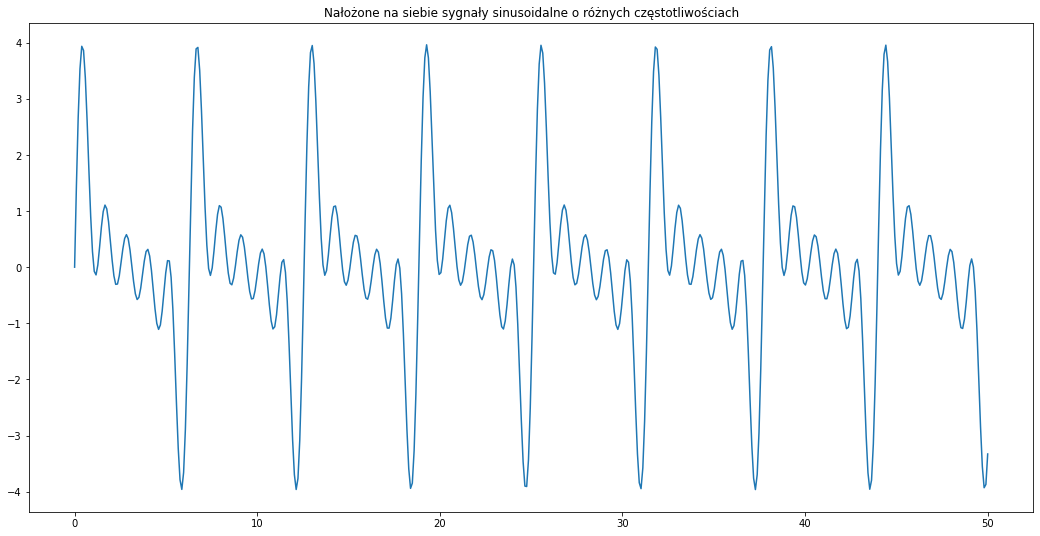

In [14]:
plt.plot(xs, overlapped_signal)
plt.title("Nałożone na siebie sygnały sinusoidalne o różnych częstotliwościach")
plt.show()

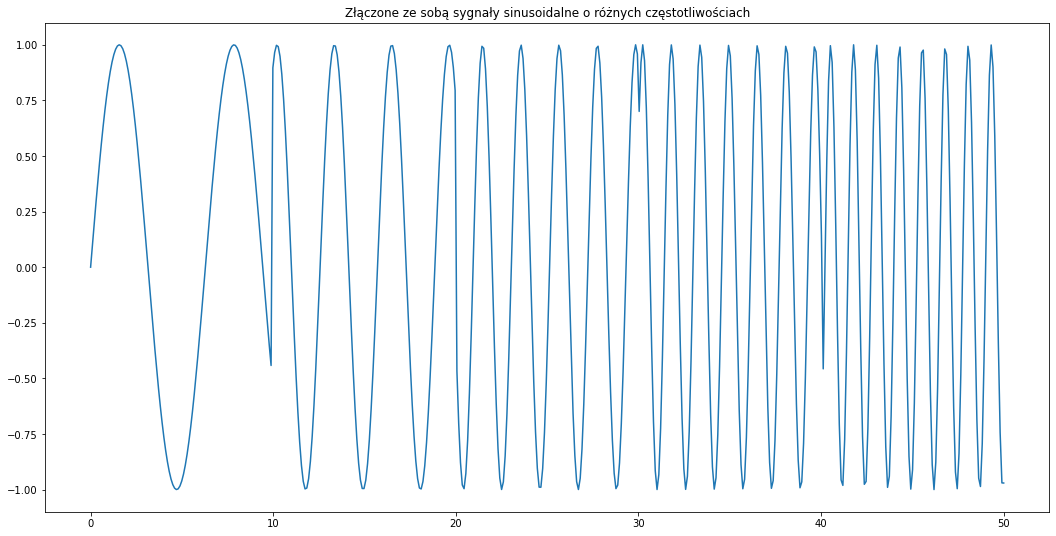

In [15]:
plt.title("Złączone ze sobą sygnały sinusoidalne o różnych częstotliwościach")
plt.plot(xs, concatenated_signal)
plt.show()

Następnie stworzyłem funkcję realizującą transformację Fouriera na przygotowanych sygnałach. Funkcja rysuje wykresy dla części rzeczywistej oraz urojonej.

In [16]:
def analyze_freq(xs, data):
    y = np.fft.fft(data)

    plt.plot(xs, np.real(y))
    plt.title("Część rzeczywista")
    plt.show()

    plt.plot(xs, np.imag(y))
    plt.title("Część urojona")
    plt.show()

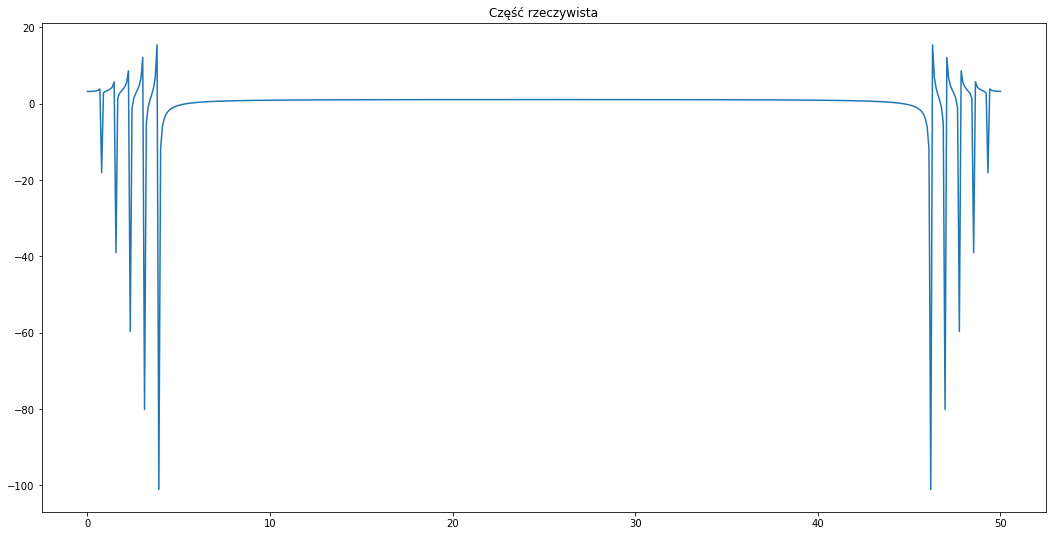

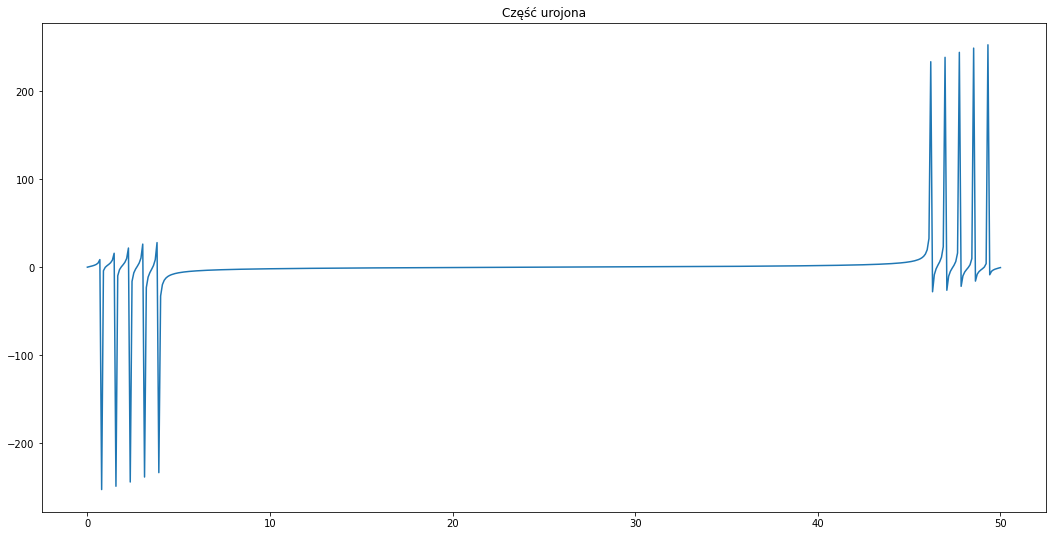

In [17]:
analyze_freq(xs, overlapped_signal)

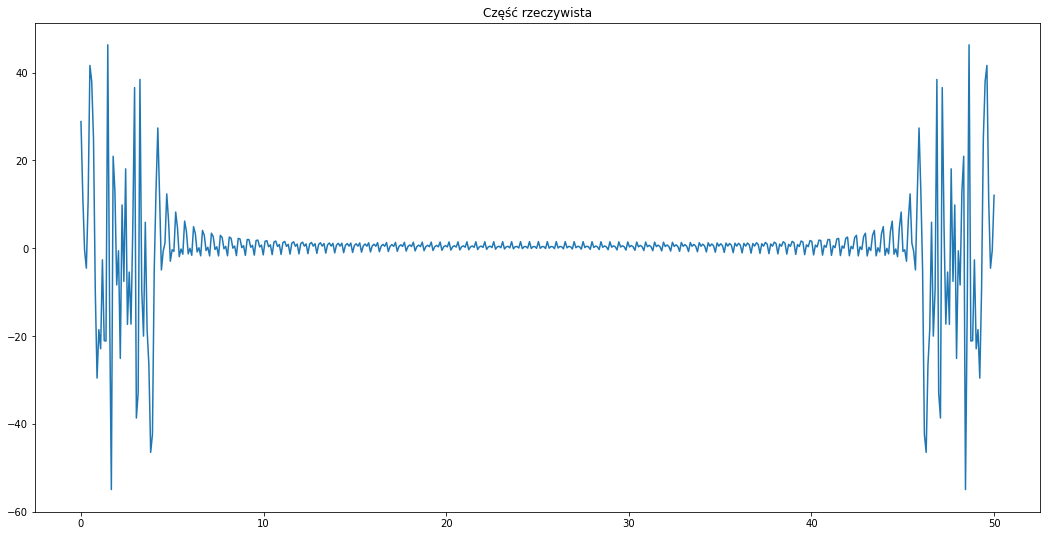

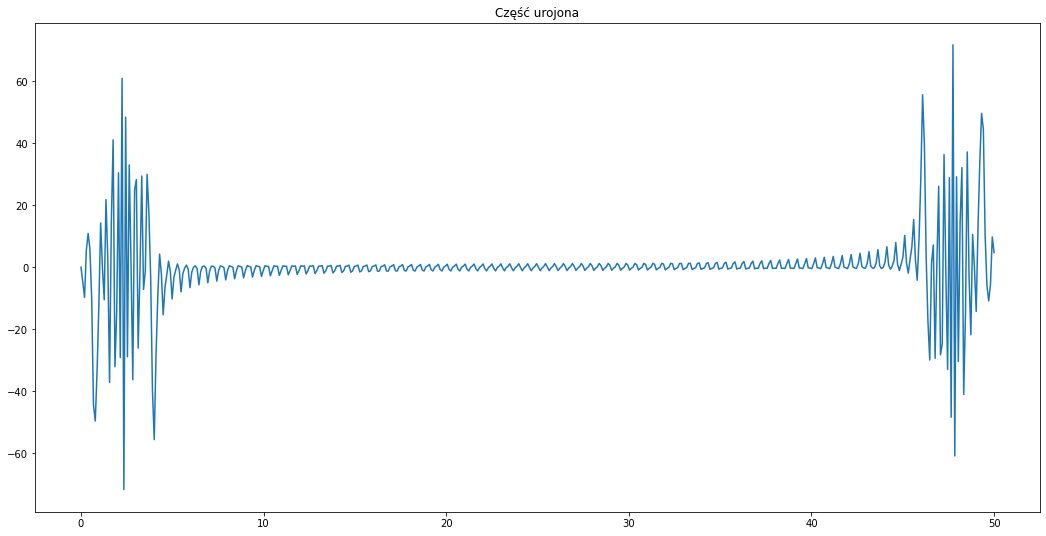

In [18]:
analyze_freq(xs, concatenated_signal)

Niezależnie od sygnału możemy zauważyć, że w obrębie końca i początku wykresu mamy tzw. peaki. Transformata Fouriera może być wykorzystana do analizy sygnałów w dziedzinie częstotliwości. Za jej pomocą możemy przeprowadzić odszumianie sygnału w prosty sposób - obliczamy dft i obcinamy wartości poniżej interesującego nas progu, następnie wystarczy zastosować IDFT i nasz sygnał jest odszumiony. 